In [27]:
import numpy as np
import pandas as pd
import arviz as az
import scipy.stats as stats
import pymc as pm
import matplotlib.pyplot as plt
import helper_functions as hf

### Quantitavely Assessing The Impact of Invididual Players in Hockey Offensive Zone Entries

# Data cleaning
Making two datasets, one for only the offensive team's players and one for the defendings team's players

In [22]:
data = pd.read_csv('Data/zone_entries_with_players.csv')
zone_entries_df = data.iloc[:, [9] + list(range(31, 82))]
shifts_df = pd.read_csv('Data/BDC_2024_Womens_Shifts.csv')

# Remove the goalies from the shifts data
players_to_remove = ['Aerin Frankel', 'Emerance Maschmeyer', 'Kristen Campbell', 'Nicole Hensley', 'Ann-Renee Desbiens']
shifts_df = shifts_df[~shifts_df['player_name'].isin(players_to_remove)]

# Get the player names and team names
player_teams_df = shifts_df[['team_name', 'player_name']].drop_duplicates().reset_index(drop=True)

This splits game entry data into two datasets by filtering each player's contributions: one dataset retains data when the player’s team matches the entry’s team (offensive), and the other retains data when it does not (defensive).

In [23]:
offensive_dataset, defensive_dataset = hf.create_offensive_defensive_datasets(zone_entries_df, player_teams_df)

This model implements a latent factor decomposition using a Poisson likelihood. For an observed $Y_{ij}$ corresponding to zone entry $i$ and player $j$, we assume

$$
Y_{ij} \sim \text{Poisson}(\lambda_{ij}),
$$

with the Poisson rate parameter defined as the dot product of two latent factors:

$$
\lambda_{ij} = \mathbf{z}_i \cdot \mathbf{w}_j^T.
$$

The latent factors are given Gamma priors:

$$
\mathbf{z}_i \sim \text{Gamma}(\alpha=1, \beta=1) \quad \text{for } i=1,\dots,N,
$$

$$
\mathbf{w}_j \sim \text{Gamma}(\alpha=1, \beta=1) \quad \text{for } j=1,\dots,M.
$$

Here, $\mathbf{z}_i$ represents the latent factors for the zone entries and $\mathbf{w}_j$ represents the latent factors for the players. In this implementation, we use a latent space of dimension 2. We choose a two-dimensional model because the dataset is very small and increasing the dimensionality does not significantly improve performance; the goal here is merely to demonstrate feasibility. 

Separate models are defined for the offensive and defensive datasets, allowing for context-specific latent representations.

In [9]:
with pm.Model() as poisson_factorization_offensive:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(offensive_dataset.shape[0], 2))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(offensive_dataset.shape[1], 2))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate, observed=offensive_dataset)

    # Sampling
    trace_offensive = pm.sample(return_inferencedata=True)
    
with pm.Model() as poisson_factorization_defensive:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(defensive_dataset.shape[0], 2))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(defensive_dataset.shape[1], 2))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate, observed=defensive_dataset)

    # Sampling
    trace_defensive = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


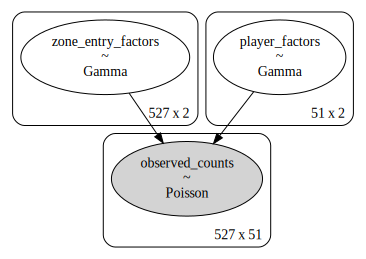

In [10]:
pm.model_to_graphviz(poisson_factorization_offensive)

# Predictive Check

This section performs predictive checks to evaluate whether the latent factor model adequately captures the structure in the data. By comparing simulated data from the model with the observed zone entry successes, we assess model fit and identify any potential mis-specifications. This process helps ensure that our inferred latent representations are reliable for subsequent analyses.


This block randomly withholds a small subset of observed counts from the offensive dataset, three player‑zone entries per row, to serve as held‑out data for predictive checking.

In [14]:
# Set the random seed for reproducibility
np.random.seed(2)
num_mask = 3
# Mask creation 
mask = np.ones_like(offensive_dataset, dtype=bool)
for i in range(offensive_dataset.shape[0]):
    mask_indices = np.random.choice(offensive_dataset.shape[1], num_mask, replace=False)
    mask[i, mask_indices] = False

In [29]:
# Compute predictive scores
offensive_score = hf.predictive_score(offensive_dataset, mask, num_mask)
defensive_score = hf.predictive_score(defensive_dataset, mask, num_mask)

print(f"Offensive held‑out predictive score: {offensive_score:.3f}")
print(f"Defensive held‑out predictive score: {defensive_score:.3f}")

AttributeError: module 'helper_functions' has no attribute 'predictive_score'